# Goal:
Create a web app that analyzes and synthesizes 2 users' spotify recent taste profiles so that we can create a playlist filled with brand new song recommendations for both of them to discover together. The playlist we curate will automatically end up in both of their spotify libraries. Would be a cool new way for people to socialize because the playlist is unique to them and can create a special experience for both to find new music together that matches their music tastes.

### Some useful links to get started: 

spotipy documentation: https://spotipy.readthedocs.io/en/2.13.0/ 

github of guy who made this code (give proper credit later): https://github.com/makispl/Spotify-Data-Analysis

In [439]:
# Import the libraries

import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format ='retina'
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import random
from pandas.io.json import json_normalize

## Authorization Flow

In [440]:
# Declare the credentials

cid = '0b2103231ba64a70885c27fbb38cfa97'
secret = '45d7d10e11474298abcb52df745e2b25'
redirect_uri='http://localhost:7777/callback'
username = 'trustinyoon'

# Authorization flow
scope = 'user-top-read'
token = util.prompt_for_user_token(username, scope, client_id=cid, client_secret=secret, redirect_uri=redirect_uri)

if token:
    sp = spotipy.Spotify(auth=token)
else:
    print("Can't get token for", username)

# Data Collection
## Extract User's Top Medium Term Songs
Spotipy has a built-in function to fetch users' top 50 songs. We extract our songs with that function in the Save_User1_Top_50_Songs.ipynb and Save_User2_Top_50_Songs.ipynb notebooks, and we import the resulting csv files from there below

In [441]:
user1_songs = pd.read_csv('User1_top_50_songs.csv')
user2_songs = pd.read_csv('User2_top_50_songs.csv')
temp = [user1_songs, user2_songs]
temp = pd.concat(temp)
temp.reset_index(drop=True,inplace=True)
temp.head(3)

,Unnamed: 0,artist,artist_uri,song,song_uri,duration_ms,explicit,album,popularity
0,0,Lil Uzi Vert,spotify:artist:4O15NlyKLIASxsJ0PrXPfz,I Can Show You,spotify:track:0AhJag7VI8uFf3mJFsTwvf,120076,True,Eternal Atake (Deluxe) - LUV vs. The World 2,66
1,1,Lil Uzi Vert,spotify:artist:4O15NlyKLIASxsJ0PrXPfz,Myron,spotify:track:56uXDJRCuoS7abX3SkzHKQ,224954,True,Eternal Atake (Deluxe) - LUV vs. The World 2,84
2,2,JACKBOYS,spotify:artist:7A8S43ryYdbWpJKeHRZRcq,GATTI,spotify:track:40mjsnRjCpycdUw3xhS20g,181144,True,JACKBOYS,79


### Extract Users' Top 50 Tracks' Audio Features

In [442]:
user1_list = []
for song in user1_songs['song_uri']:
    row = pd.DataFrame(sp.audio_features(tracks=[song]))
    user1_list.append(row)
user1_df = pd.concat(user1_list)

user2_list = []
for song in user2_songs['song_uri']:
    row = pd.DataFrame(sp.audio_features(tracks=[song]))
    user2_list.append(row)
user2_df = pd.concat(user2_list)

# Combine both users' top 50 songs into one dataframe of 100 songs

dfs = [user1_df, user2_df]
dfs = pd.concat(dfs)
dfs.head(3)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.817,0.656,10,-7.086,0,0.277,0.051,0.0,0.115,0.314,139.915,audio_features,0AhJag7VI8uFf3mJFsTwvf,spotify:track:0AhJag7VI8uFf3mJFsTwvf,https://api.spotify.com/v1/tracks/0AhJag7VI8uF...,https://api.spotify.com/v1/audio-analysis/0AhJ...,120076,4
0,0.771,0.654,8,-6.976,0,0.298,0.055,0.0,0.214,0.573,155.047,audio_features,56uXDJRCuoS7abX3SkzHKQ,spotify:track:56uXDJRCuoS7abX3SkzHKQ,https://api.spotify.com/v1/tracks/56uXDJRCuoS7...,https://api.spotify.com/v1/audio-analysis/56uX...,224955,4
0,0.594,0.676,2,-5.808,1,0.344,0.135,0.0,0.163,0.472,143.477,audio_features,40mjsnRjCpycdUw3xhS20g,spotify:track:40mjsnRjCpycdUw3xhS20g,https://api.spotify.com/v1/tracks/40mjsnRjCpyc...,https://api.spotify.com/v1/audio-analysis/40mj...,181145,4


#### Data Cleaning

In [443]:
# Drop unnecessary features

dfs.drop(['type','track_href','analysis_url','time_signature','duration_ms','uri','instrumentalness','liveness','loudness','key','mode'],1,inplace=True)
dfs.set_index('id',inplace=True)
dfs.head(3)

,danceability,energy,speechiness,acousticness,valence,tempo
id,,,,,,
0AhJag7VI8uFf3mJFsTwvf,0.817,0.656,0.277,0.051,0.314,139.915
56uXDJRCuoS7abX3SkzHKQ,0.771,0.654,0.298,0.055,0.573,155.047
40mjsnRjCpycdUw3xhS20g,0.594,0.676,0.344,0.135,0.472,143.477


In [444]:
# Normalize tempo feature

columns = ['danceability','energy','speechiness','acousticness','valence','tempo']
scaler = MinMaxScaler()
scaler.fit(dfs[columns])
dfs[columns] = scaler.transform(dfs[columns])
dfs.head(3)

,danceability,energy,speechiness,acousticness,valence,tempo
id,,,,,,
0AhJag7VI8uFf3mJFsTwvf,0.856777,0.700288,0.285061,0.056722,0.303797,0.646449
56uXDJRCuoS7abX3SkzHKQ,0.797954,0.698124,0.309083,0.061171,0.577004,0.787933
40mjsnRjCpycdUw3xhS20g,0.571611,0.721928,0.361702,0.150160,0.470464,0.679754


In [446]:
# Check out features summary

dfs.describe()

,danceability,energy,speechiness,acousticness,valence,tempo
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.696637,0.704689,0.203172,0.202933,0.495424,0.463528
std,0.196132,0.178690,0.181131,0.225125,0.235469,0.256441
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.541880,0.587219,0.040809,0.030387,0.335179,0.268585
50%,0.744246,0.725174,0.172958,0.117901,0.470992,0.445405
75%,0.858056,0.851767,0.311656,0.296157,0.667722,0.645888
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Building the Song Recommender
## K-Means Cluster Analysis
We used k-means clustering to identify clusters of similar songs (essentially subgenres) in the dataframe that combines all our favorite recent songs together. This would allow us to  

In [392]:
# Get 20 clusters of x songs -> perform the recommendation function 20 times 

clusters = 20
kmeans = KMeans(n_clusters=clusters)
kmeans.fit(dfs)
len(kmeans.labels_)

100

### Visualize Clustering

In [393]:
from sklearn.decomposition import PCA 

pca = PCA(3) 
pca.fit(dfs) 
  
pca_data = pd.DataFrame(pca.transform(dfs)) 
  
print(pca_data.head())

          0         1         2
0  0.135352  0.100821 -0.184984
1  0.358808  0.030468 -0.048931
2  0.218774  0.152245 -0.047810
3 -0.068135 -0.364285  0.038947
4  0.248385 -0.190958  0.006700


In [394]:
from matplotlib import colors as mcolors 
import math 
   
''' Generating different colors in ascending order  
                                of their hsv values '''
colors = list(zip(*sorted(( 
                    tuple(mcolors.rgb_to_hsv( 
                          mcolors.to_rgba(color)[:3])), name) 
                     for name, color in dict( 
                            mcolors.BASE_COLORS, **mcolors.CSS4_COLORS 
                                                      ).items())))[1] 
   
   
# number of steps to taken generate n(clusters) colors  
skips = math.floor(len(colors[5 : -5])/clusters) 
cluster_colors = colors[5 : -5 : skips] 

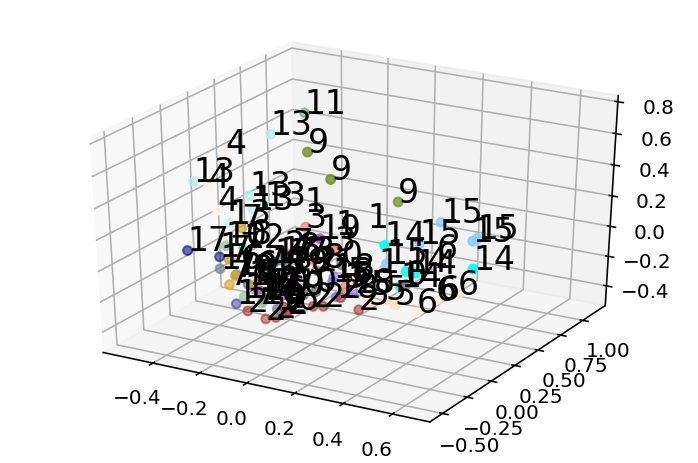

In [395]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt 
from matplotlib.animation import FuncAnimation
   
fig = plt.figure() 
ax = fig.add_subplot(111, projection = '3d') 
ax.scatter(pca_data[0], pca_data[1], pca_data[2],  
           c = list(map(lambda label : cluster_colors[label], 
                                            kmeans.labels_))) 
   
str_labels = list(map(lambda label:'% s' % label, kmeans.labels_)) 
   
list(map(lambda data1, data2, data3, str_label: 
        ax.text(data1, data2, data3, s = str_label, size = 16.5, 
        zorder = 20, color = 'k'), pca_data[0], pca_data[1], 
        pca_data[2], str_labels)) 

plt.show()

### Cluster Analysis

In [396]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(dfs)
y_kmeans = kmeans.fit_predict(scaled)
y_kmeans

array([10,  7,  7, 13,  7,  4,  1,  7, 13,  5,  0, 10, 14,  6, 17, 15, 12,
       13,  1,  9, 15, 13,  2, 10, 18,  3,  6,  1,  0, 17, 15, 12,  5,  1,
        0,  1,  9, 17, 15,  7, 17, 13,  6, 18,  8,  7, 14,  3, 19, 17, 12,
       14, 14,  6,  3,  8,  9,  8, 14,  5, 14, 12,  8,  7,  2,  2,  9, 16,
        1,  5,  8,  7, 14, 14,  1,  6,  9, 10, 12,  2,  7,  9,  2,  2, 18,
        9, 17, 15,  9,  2,  7, 18,  3, 13, 13,  8, 11,  5,  6,  5],
      dtype=int32)

In [397]:
# Updating dataframe with assigned clusters 

dfs['cluster'] = y_kmeans
dfs['artist'] = temp.artist.tolist()
dfs['title'] = temp.song.tolist()
dfs.head()

,danceability,energy,speechiness,acousticness,valence,tempo,cluster,artist,title
id,,,,,,,,,
0AhJag7VI8uFf3mJFsTwvf,0.856777,0.700288,0.285061,0.056722,0.303797,0.646449,10,Lil Uzi Vert,I Can Show You
56uXDJRCuoS7abX3SkzHKQ,0.797954,0.698124,0.309083,0.061171,0.577004,0.787933,7,Lil Uzi Vert,Myron
40mjsnRjCpycdUw3xhS20g,0.571611,0.721928,0.361702,0.150160,0.470464,0.679754,7,JACKBOYS,GATTI
3hR48Bj9Wgl6xunDG4nsRZ,0.842711,0.865833,0.150080,0.156834,0.695148,0.226896,13,Kid Cudi,Leader Of The Delinquents
4lAQfuREAHG8IC0PiiigBt,0.914322,0.693796,0.374285,0.023017,0.666667,0.564908,7,Lil Uzi Vert,Strawberry Peels (feat. Young Thug & Gunna)


## Visualizing different clusters' features

In [398]:
# Removing clusters that only have one song in them

delete_clusters = []
cluster = 0
while cluster < (len(dfs.cluster.unique())-1):
    if dfs.groupby('cluster').count().loc[cluster].danceability == 1:
        delete_clusters.append(cluster)
    cluster+=1
    
delete_clusters

[4, 11, 16]

In [399]:
dfs.reset_index(inplace=True)

In [400]:
i = 0
while i < (len(dfs.cluster.unique())-1):
    if dfs.loc[[i]].cluster.tolist()[0] in delete_clusters:
        dfs.drop(i,0,inplace=True)
    i+=1

In [401]:
dfs.groupby('cluster').count()

,id,danceability,energy,speechiness,acousticness,valence,tempo,artist,title
cluster,,,,,,,,,
0,3,3,3,3,3,3,3,3,3
1,7,7,7,7,7,7,7,7,7
2,7,7,7,7,7,7,7,7,7
3,4,4,4,4,4,4,4,4,4
5,6,6,6,6,6,6,6,6,6
6,6,6,6,6,6,6,6,6,6
7,10,10,10,10,10,10,10,10,10
8,6,6,6,6,6,6,6,6,6
9,8,8,8,8,8,8,8,8,8


In [402]:
dfs.set_index('id',inplace=True)

In [403]:
# Create list of lists of song ids to put into recommendation function
i=0
list_of_recs = [0]*len(dfs.groupby('cluster').count())
while i<len(dfs.groupby('cluster').count()):
    list_of_recs[i] = dfs.loc[dfs['cluster'] == i].index.to_list()
    i+=1

list_of_recs = [ele for ele in list_of_recs if ele != []] 
len(list_of_recs)

18

In [422]:
# Adjust list for clusters so that each cluster has a maximum of 5 seed songs

j = 0
adj_list_of_recs = [0]*len(list_of_recs)
while j<len(list_of_recs):
    if 0 < len(list_of_recs[j]) < 6:
        adj_list_of_recs[j] = list_of_recs[j]
    elif len(list_of_recs[j]) > 5:
        adj_list_of_recs[j] = random.sample(list_of_recs[j], 5)
    j += 1

len(adj_list_of_recs)

18

In [423]:
#Time to Get Recommendations

k = 0
list_of_recommendations = [0]*len(list_of_recs)
while k < len(list_of_recs):
    if len(adj_list_of_recs[k]) < 4:
        list_of_recommendations[k] = sp.recommendations(seed_tracks=adj_list_of_recs[k],limit=1)
    else:
        list_of_recommendations[k] = sp.recommendations(seed_tracks=adj_list_of_recs[k],limit=2)
    k += 1
    
pd.json_normalize(list_of_recommendations[15], record_path='tracks').id

0    5QVVZCiiLA4U6ZPA1OXU5f
Name: id, dtype: object

In [424]:
list_of_recommendations_converted = [0]*len(list_of_recs)

l = 0
while l < len(list_of_recs):
    list_of_recommendations_converted.append(pd.json_normalize(list_of_recommendations[l], record_path='tracks').id.tolist())
    l += 1

no_integers = [x for x in list_of_recommendations_converted if not isinstance(x, int)]
list_of_recommendations_converted = [item for elem in no_integers for item in elem]

len(list_of_recommendations_converted)

33

## Create the New Playlist
Next, we are going to create a new playlist and add to it all the tracks we ended up selecting:

In [425]:
# Authorization flow

scope = "playlist-modify-public"
token = util.prompt_for_user_token(username, scope, client_id=cid, client_secret=secret, redirect_uri=redirect_uri)

if token:
    sp = spotipy.Spotify(auth=token)
else:
    print("Can't get token for", username)

In [426]:
# Create new playlist and insert it straight to user's library
def create_playlist(sp, username, playlist_name, playlist_description):
    playlists = sp.user_playlist_create(username, playlist_name, description = playlist_description)

In [427]:
create_playlist(sp, username, 'Spotify Discover Together', 'Choose a friend to discover brand new music with. We create an adventurous playlist curated to both of your tastes!')

In [428]:
# Fetch user's playlist library

def fetch_playlists(sp, username):
    """
    Returns the user's playlists.
    """
        
    id = []
    name = []
    num_tracks = []
    
    # Make the API request
    playlists = sp.user_playlists(username)
    for playlist in playlists['items']:
        id.append(playlist['id'])
        name.append(playlist['name'])
        num_tracks.append(playlist['tracks']['total'])

    # Create the final df   
    df_playlists = pd.DataFrame({"id":id, "name": name, "#tracks": num_tracks})
    return df_playlists

In [429]:
# Find the new playlist's id
fetch_playlists(sp,username).head(3)

,id,name,#tracks
0,6C2Vcgg3ibWwqgRLWJyo1C,Spotify Discover Together,0
1,0V4FzMOSwDfXefUZMfB5ou,여,76
2,0oC7KjO0OYwBZ7fGHRZDqs,waH,18


In [430]:
extracted_id = fetch_playlists(sp,username).id[0]

In [432]:
# Finally, fill the new playlist with the recommended songs straight to the user's library!
sp.user_playlist_add_tracks(username, extracted_id, list_of_recommendations_converted, position=None)

{'snapshot_id': 'Myw3MzEzZjQ0ZTE4ZDNhM2I3ODA4NjMwYzUwMmQ1MzMwMzAwZTVhNTg0'}